In [5]:
# required to import local package

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
config = {
  "save_plots": False,
  "load_models": False,
}

In [7]:
import torch
from ogb.nodeproppred import PygNodePropPredDataset

# download dataset using ogb pytorch geometric loader.
dataset = PygNodePropPredDataset(name="ogbn-arxiv")

data = dataset[0] # pyg graph object

print(data)

Data(num_nodes=169343, edge_index=[2, 1166243], x=[169343, 128], node_year=[169343, 1], y=[169343, 1])


In [9]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

matplotlib.rcParams['lines.linewidth'] = 4
matplotlib.rcParams['lines.markersize'] = 14
matplotlib.rcParams['figure.figsize'] = [15, 12]
font = {'size': 32}
matplotlib.rc('font', **font)
alpha = 1

for ts in [2010,2013,2016,2020]:
  y = data.y[data.node_year <= ts].reshape(-1).detach().numpy()
  classes = np.unique(y)
  bins = np.append(classes, np.max(y)+1)

  hist = plt.hist(y, bins=bins, rwidth=0.8, color="#4363d8")
  print(hist)

  #plt.xticks(None)
  plt.title(f"Class distribution - OGB Arxiv - Time step {ts}")
  plt.xlabel("Class")
  plt.ylabel("Number of node")
  plt.grid(True)

  plt.tight_layout()
  output_dir = "plots"
  os.makedirs(output_dir, exist_ok=True)
  plt.savefig(f"{output_dir}/arxiv-class-dist-{ts}.png")
  plt.close()
  # plt.show()

(array([  63.,   36.,  887.,  122.,  403.,  485.,  147.,   71.,  619.,
        650., 1134.,   83.,    9.,  197.,  137.,   52.,  200.,   25.,
          6.,    9.,  331.,   63.,  283.,  247.,  455.,   12.,   37.,
        143., 3122.,   33.,  399.,  182.,   33.,  116.,  935.,   24.,
        384.,  289.,  202.,  349.]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40]), <a list of 40 Patch objects>)
(array([ 165.,  109., 1779.,  278.,  980., 1090.,  199.,  165., 1624.,
       1230., 2825.,  177.,   16.,  412.,  262.,  100.,  868.,   50.,
         78.,  336.,  704.,  143.,  574.,  529., 1900.,   28.,  696.,
        322., 7197.,   92.,  682.,  485.,   98.,  377., 2304.,   44.,
       1080.,  728.,  509.,  736.]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3

graph is strongly connected component: False
graph is weakly connected component: True
graph has # weakly connected components: 1
graph has # isolated nodes: 0


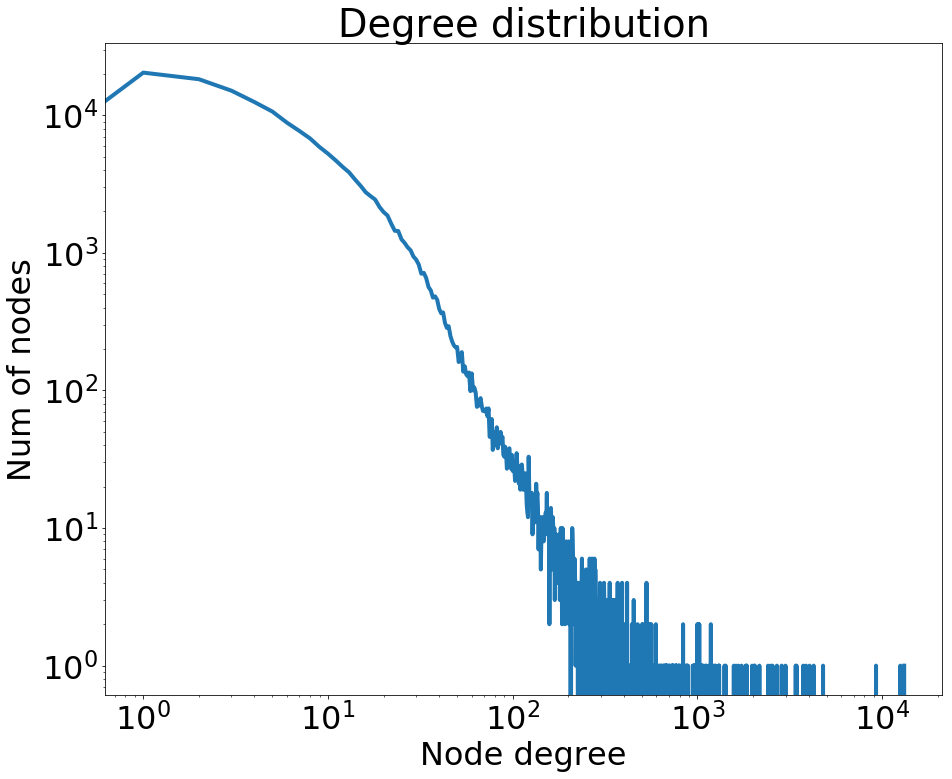

In [10]:
from lib import util

util.describe_graph(data, save_fig=config["save_plots"], log_scale=True)

## Split data set

year: 2010
year: 2011
year: 2012
year: 2013
year: 2014
year: 2015
year: 2016
year: 2017
year: 2018
year: 2019
year: 2020
graph sizes
year: 2010, # nodes: 12974, # edges: 21090


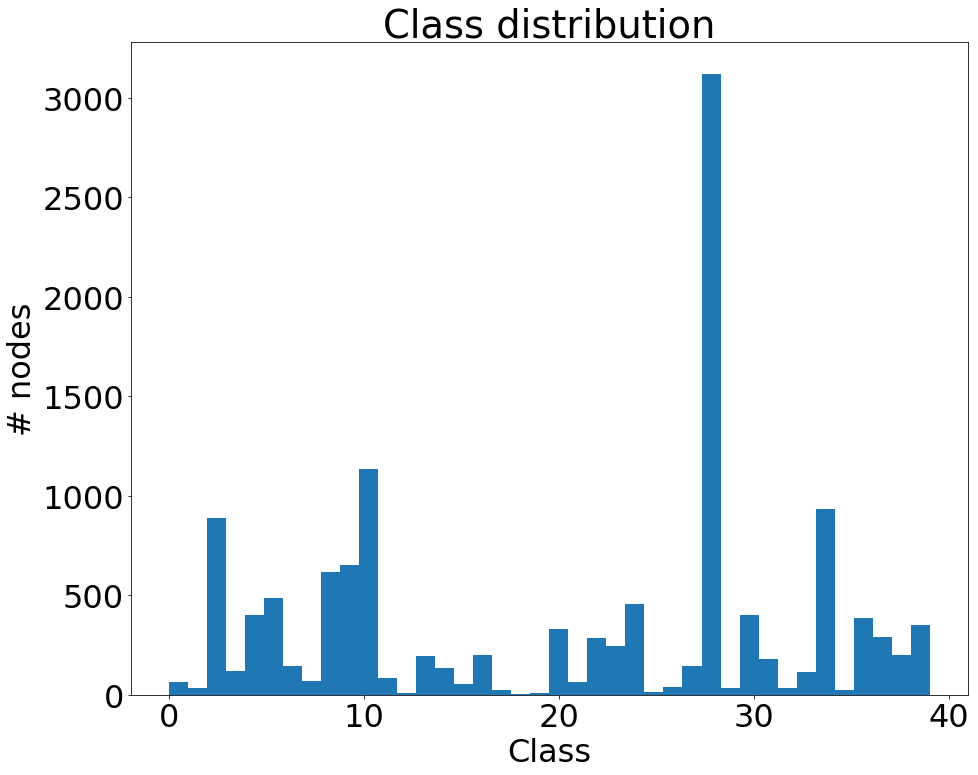

year: 2011, # nodes: 17401, # edges: 31661


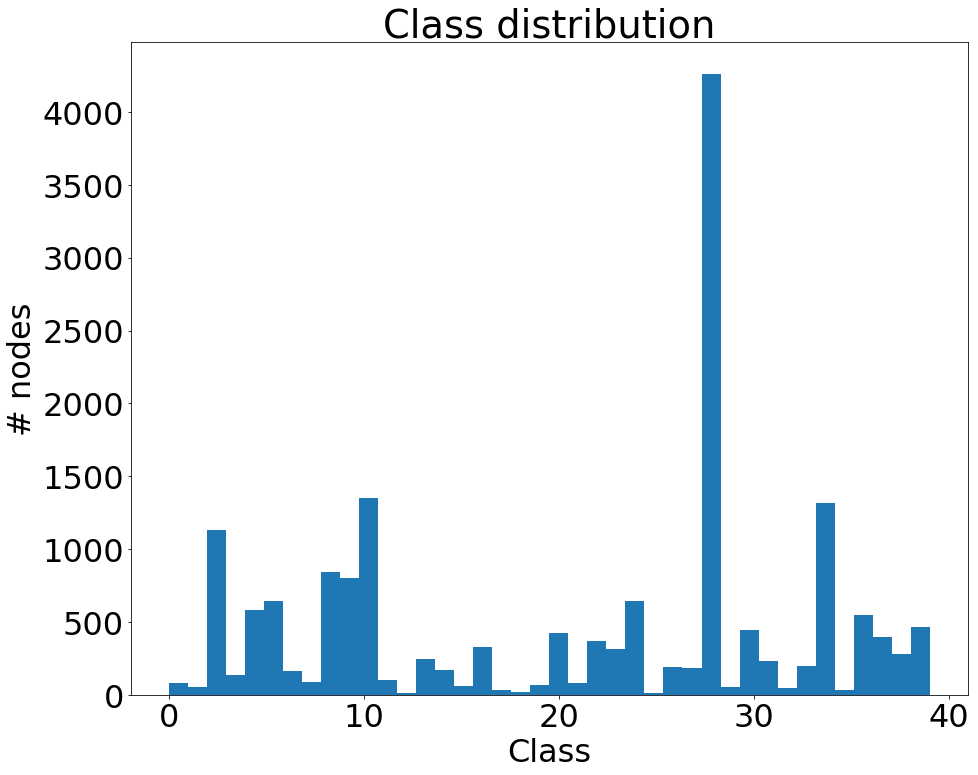

year: 2012, # nodes: 23836, # edges: 47335


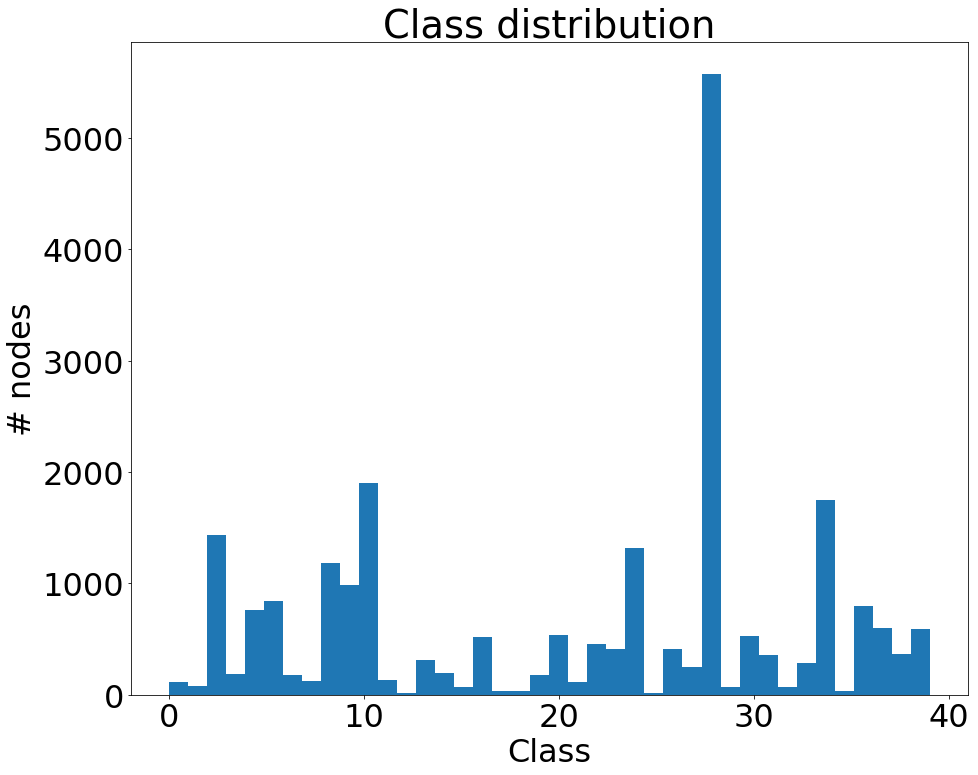

year: 2013, # nodes: 31971, # edges: 71669


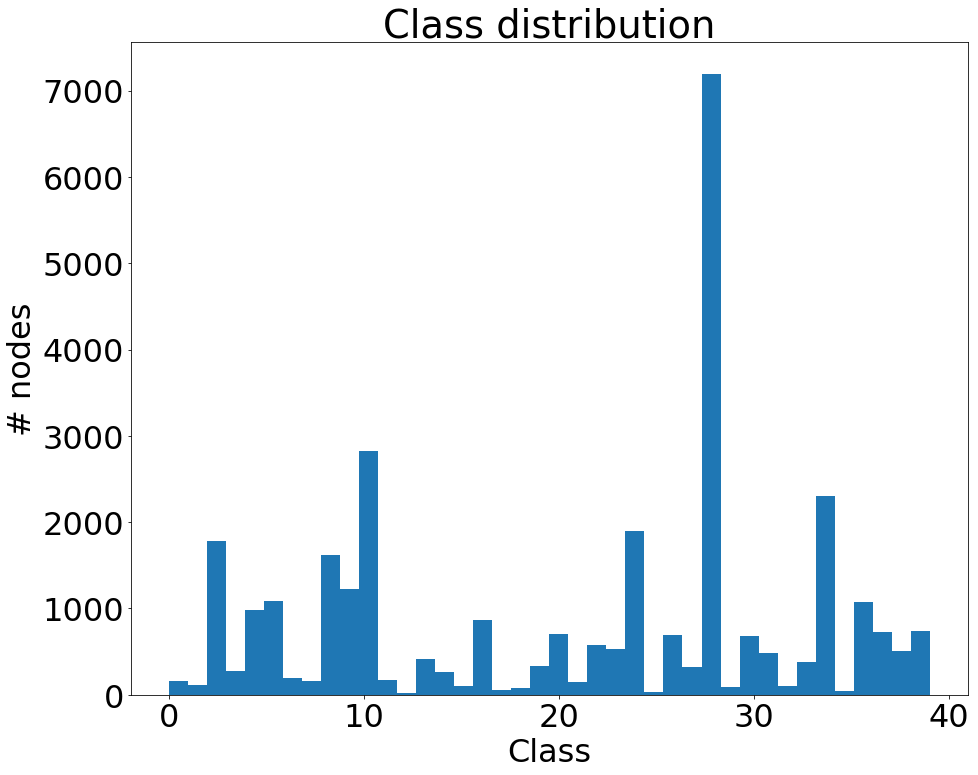

year: 2014, # nodes: 41125, # edges: 102316


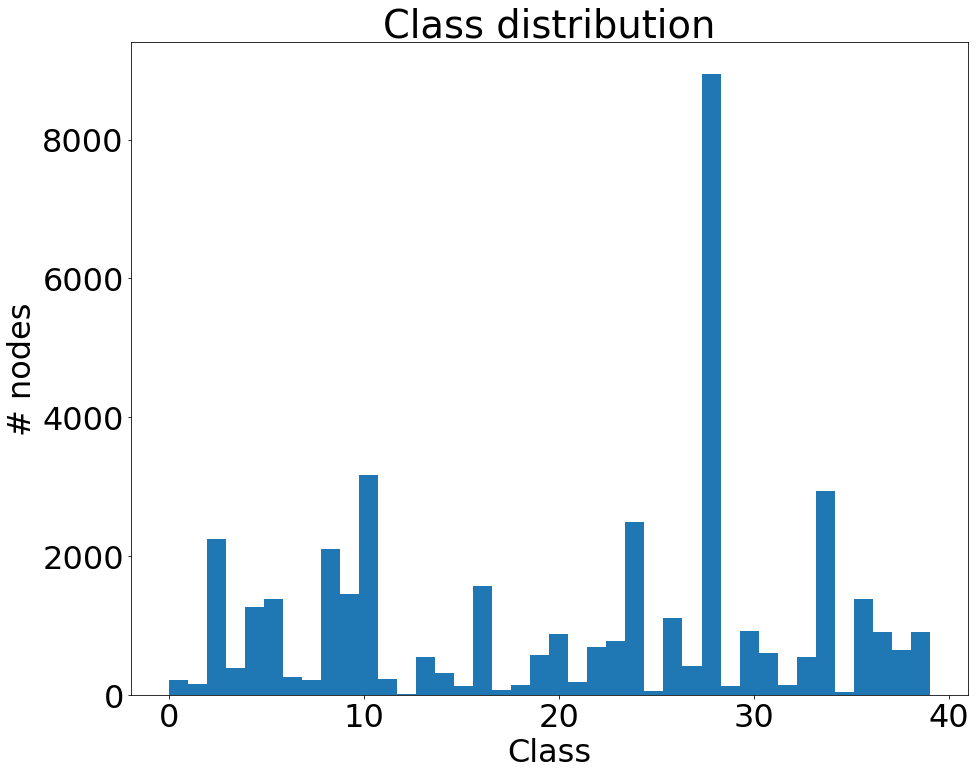

year: 2015, # nodes: 53160, # edges: 152226


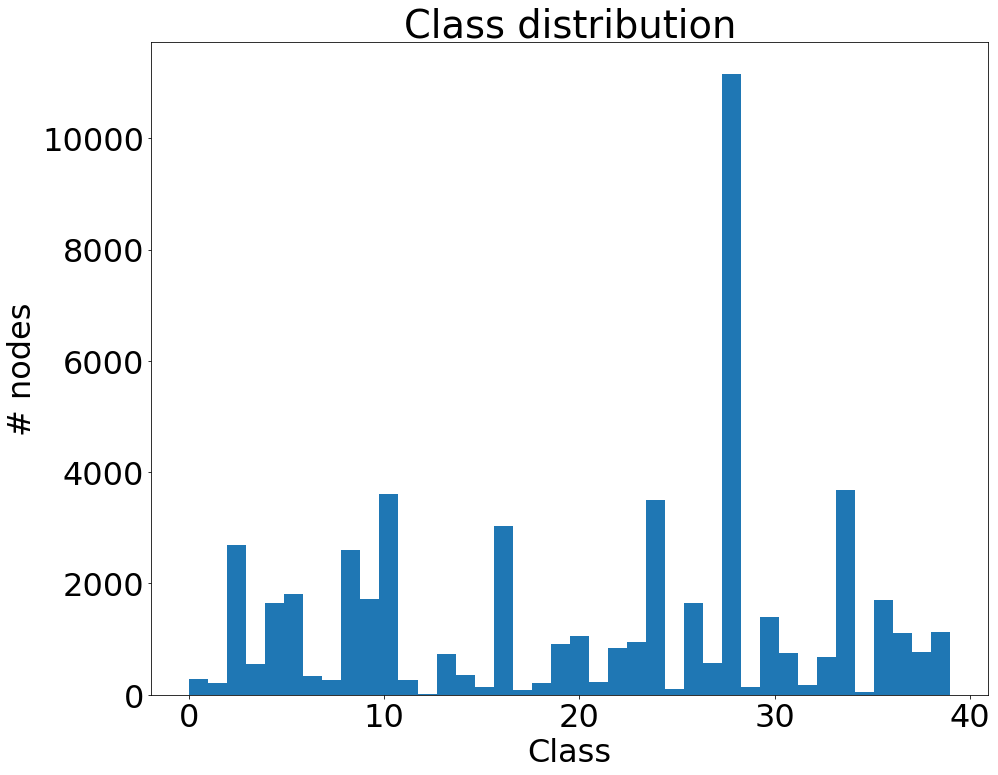

year: 2016, # nodes: 69499, # edges: 237163


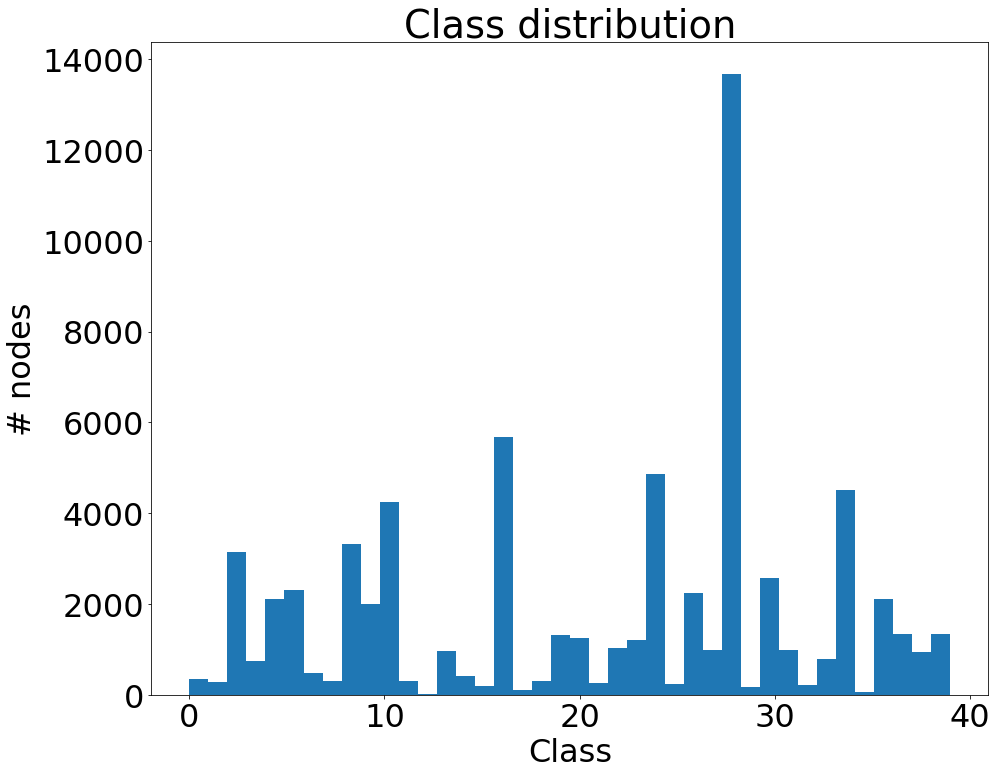

year: 2017, # nodes: 90941, # edges: 374839


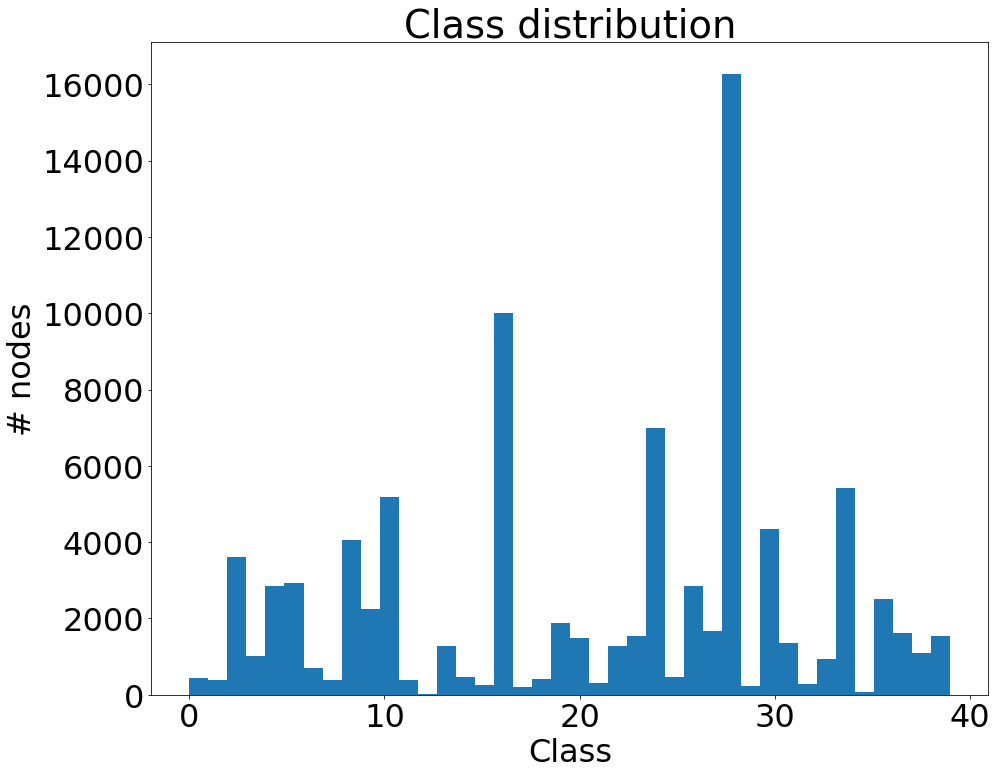

year: 2018, # nodes: 120740, # edges: 622466


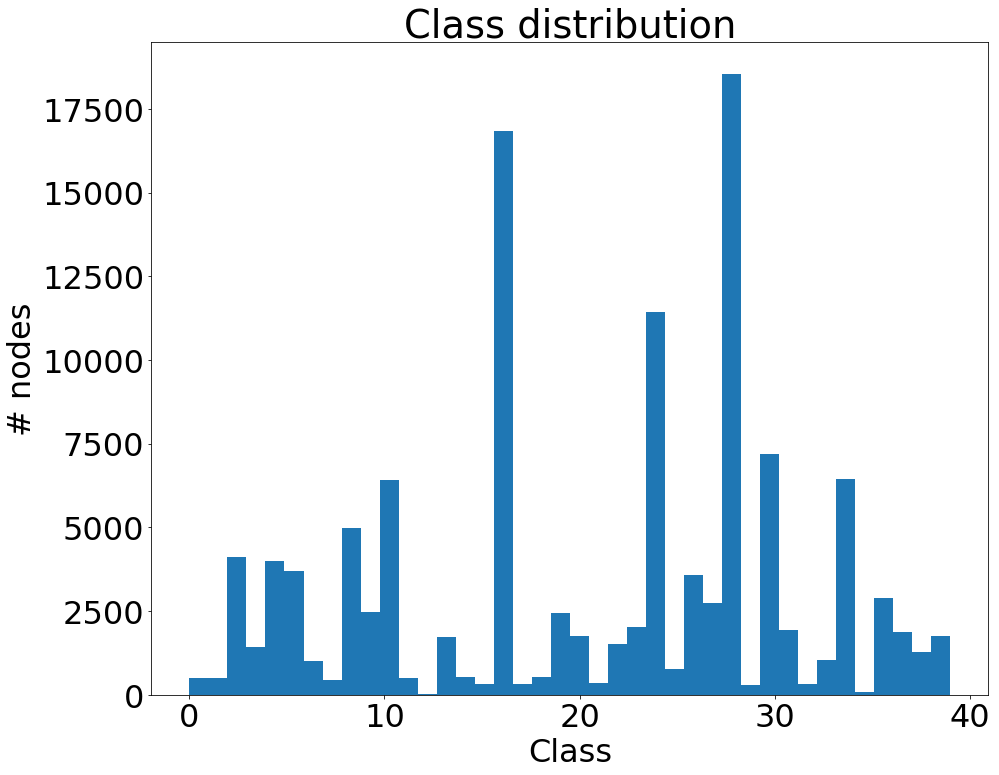

year: 2019, # nodes: 160451, # edges: 1061197


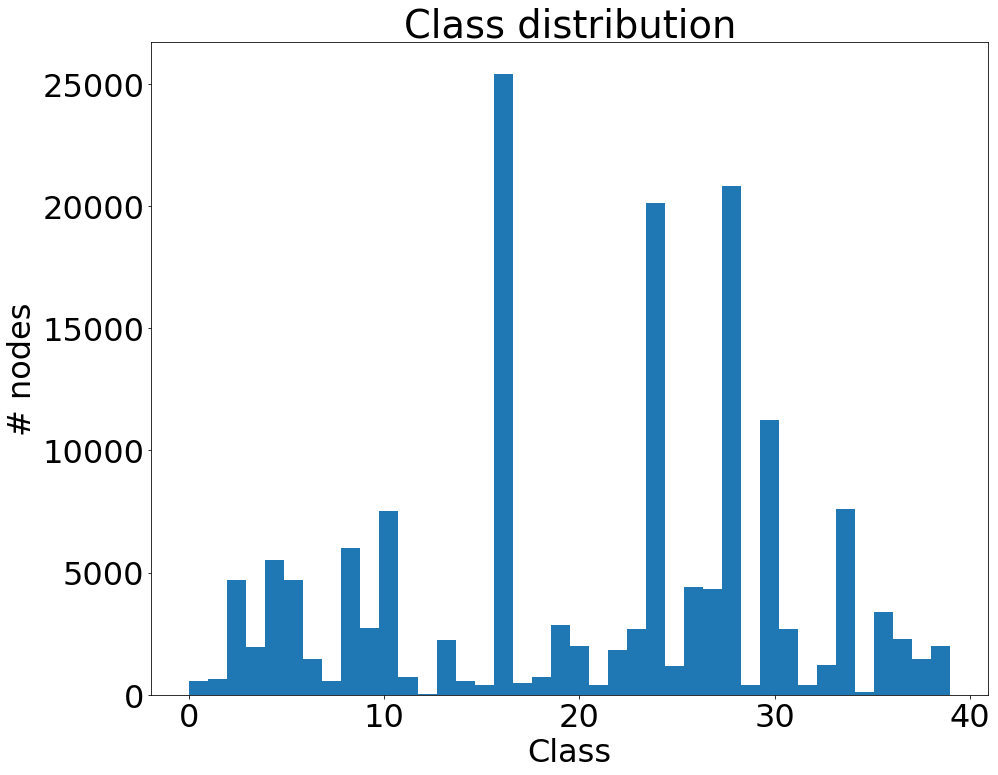

year: 2020, # nodes: 169343, # edges: 1166243


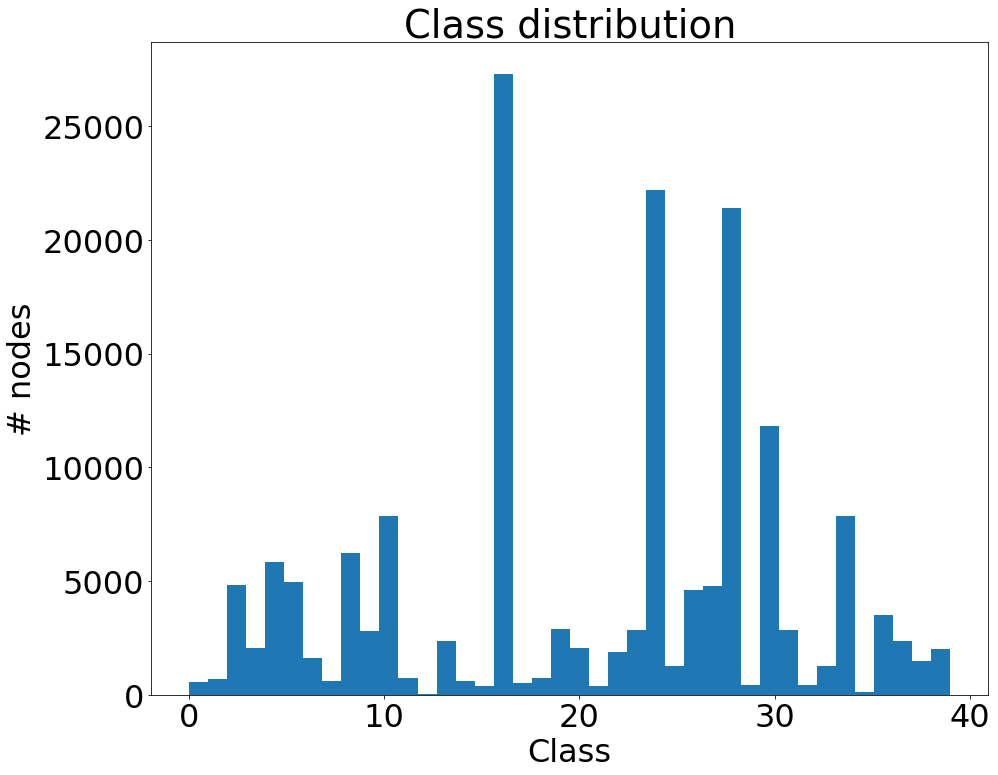

In [11]:
from lib.data import split_dataset, split

graphs = []

node_years = range(2010,2021)

for year in node_years:
  print("year: {}".format(year))
  indices = torch.nonzero(torch.where(data.node_year[:,0] <= year, 1, 0))[:,0].tolist()

  year_data = split(data, indices)

  # TODO: Retrieve test_indices only from current year
  train_data, calibration_indices, test_indices = split_dataset(year_data, test_frac=0.2, calibration_frac=0.2)
  graphs.append({
    "year": year,
    "data": year_data,
    "train_data": train_data,
    "calibration_indices": calibration_indices,
    "test_indices": test_indices,
  })

print("graph sizes")
for graph in graphs:
  print("year: {}, # nodes: {}, # edges: {}".format(graph["year"], graph["data"].x.shape[0], graph["data"].edge_index.shape[1]))
  plt.title("Class distribution")
  plt.hist(graph["data"].y.reshape(-1).detach().numpy(), dataset.num_classes)
  plt.xlabel("Class")
  plt.ylabel("# nodes")
  plt.show()

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# If you use GPU, the device should be cuda
print('Device: {}'.format(device))

for graph in graphs:
    graph["train_data"] = graph["train_data"].to(device)
    graph["data"] = graph["data"].to(device)

# data = data.to(device)

Device: cuda


# GraphSAGE model

In [17]:
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
    """
      sampling_size: number of neighbors to sample at each layer (list[int]).
    """
    super(GraphSAGE, self).__init__()

    self.num_layers = num_layers

    self.convs = torch.nn.ModuleList()
    self.bns = torch.nn.ModuleList()

    # input layer
    self.convs.append(SAGEConv(in_channels=input_dim, out_channels=hidden_dim, aggr="mean"))
    self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

    # hidden layers
    for _ in range(0, num_layers-1):
      self.convs.append(SAGEConv(in_channels=hidden_dim, out_channels=hidden_dim, aggr="mean"))
      self.bns.append(torch.nn.BatchNorm1d(hidden_dim))

    # output layer
    self.convs.append(SAGEConv(in_channels=hidden_dim, out_channels=output_dim, aggr="mean"))

    self.softmax = torch.nn.LogSoftmax(dim=1)

    self.dropout = 0.1

    self.return_embeds = False

  def reset_parameters(self):
    for conv in self.convs:
        conv.reset_parameters()

  def forward(self, x, adj_t):
    embedding = x
    for i, conv in enumerate(self.convs[:-1]):
      embedding = conv(x=embedding, edge_index=adj_t)
      embedding = self.bns[i](embedding)
      embedding = torch.nn.functional.relu(embedding)
      embedding = torch.nn.functional.dropout(embedding, p=self.dropout, training=self.training)
    
    # output layer
    class_embedding = self.convs[-1](x=embedding, edge_index=adj_t)

    node_class = self.softmax(class_embedding)

    if self.return_embeds:
      return node_class, embedding

    return node_class

  def train_model(self, data, optimizer, loss_fn):
    self.train()

    optimizer.zero_grad()
    
    out = self(data.x, data.edge_index)

    y_true = data.y.reshape(-1).detach()

    loss = loss_fn(out, y_true)

    loss.backward()
    optimizer.step()
  
  def predict(self, data):
    self.eval()
    
    if self.return_embeds:
        y_hat, embeddings = self(data.x, data.edge_index)
        return y_hat.clone().detach(), embeddings
        
    y_hat = self(data.x, data.edge_index)
    
    return y_hat.clone().detach()

  def set_return_embeds(self, return_embeds: bool):
    self.return_embeds = return_embeds


# K-Means with graphsage trained on only first time step

In [20]:
args = {
    "num_layers": 1,
    "hidden_dim": 512,
    "lr": 0.01, # learning rate
    "epochs": 100,
    "batch_size": 128,
    "num_neighbors": [1],
    "max_stagnation": 15,
}

model = GraphSAGE(data.num_features, args["hidden_dim"], dataset.num_classes, args["num_layers"]).cuda()


# reset the parameters to initial random value
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])

loss_fn = torch.nn.NLLLoss()

train_data = graphs[0]["train_data"]

for epoch in range(1, 1 + args["epochs"]):
    print(f"Epoch: {epoch:02d}")
    loss = model.train_model(train_data, optimizer, loss_fn)
    
# evaluate
model.eval()

y_hat = model.predict(data)
y_hat = y_hat[test_indices]
y_hat = y_hat.argmax(dim=-1, keepdim=True).reshape(-1)

y_true = data.y[test_indices].reshape(-1)

known_class_mask = y_true != -1
test_acc, test_f1_class_0, test_f1_class_1 = get_binary_classification_performance(y_hat[known_class_mask], y_true[known_class_mask])

print(f"Model found \n"
        f"Test acc: {100 * test_acc:.2f}%, "
        f"Test f1 (class 0): {100 * test_f1_class_0:.2f}%, "
        f"Test f1 (class 1): {100 * test_f1_class_1:.2f}%")

Epoch: 01
Epoch: 02
Epoch: 03
Epoch: 04
Epoch: 05
Epoch: 06
Epoch: 07
Epoch: 08
Epoch: 09
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

RuntimeError: Tensor for argument #2 'mat1' is on CPU, but expected it to be on GPU (while checking arguments for addmm)

KeyboardInterrupt: 

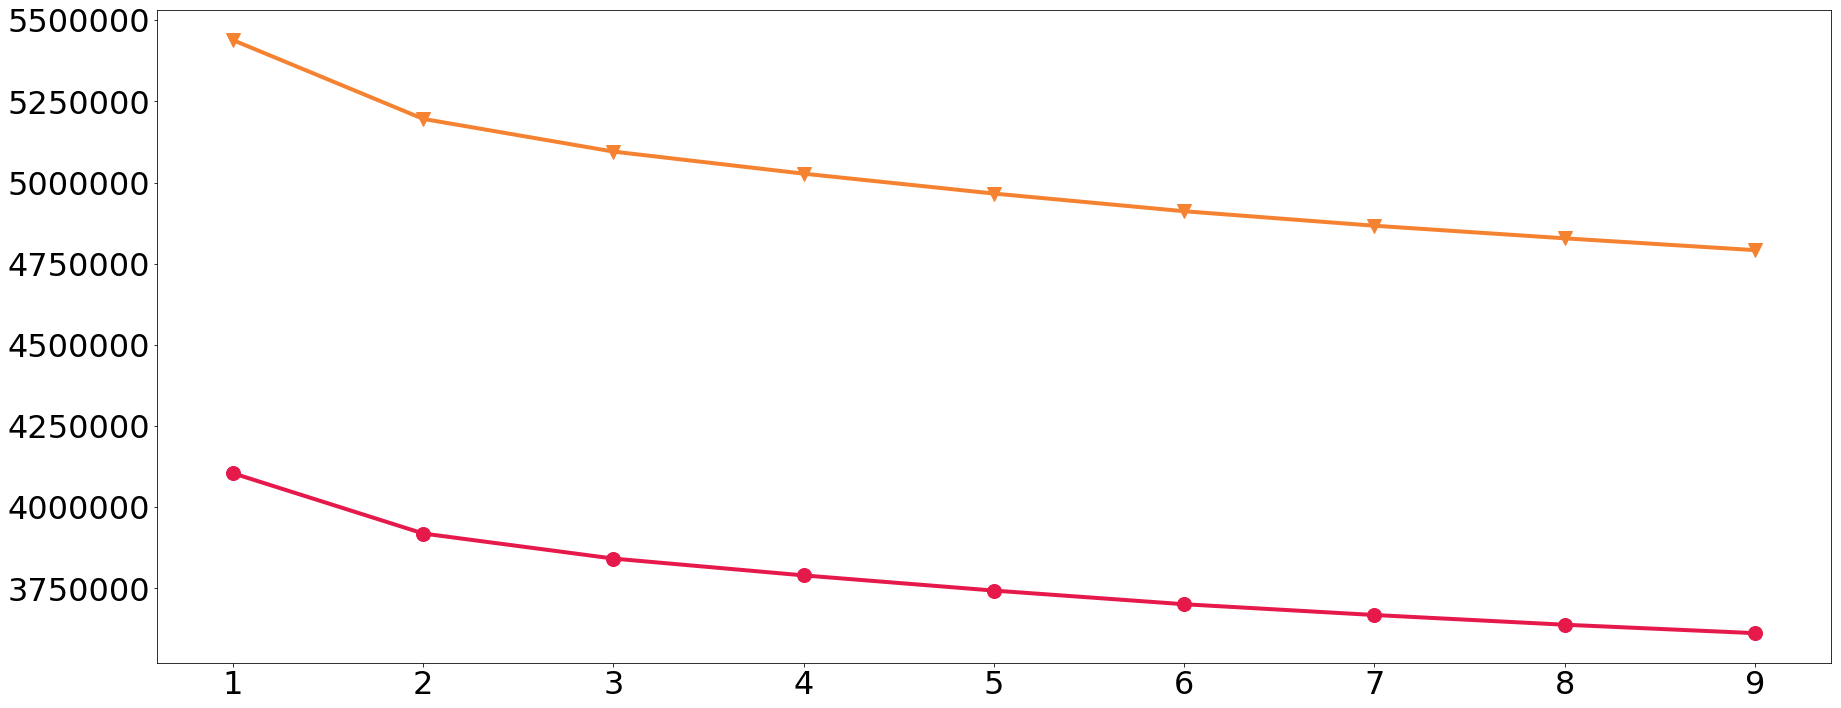

In [24]:
import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

matplotlib.rcParams['lines.linewidth'] = 4
matplotlib.rcParams['lines.markersize'] = 14
matplotlib.rcParams['figure.figsize'] = [30, 12]
font = {'size': 32}
matplotlib.rc('font', **font)

markers = itertools.cycle(['o', 'v', '^', 'X', 's', 'p', 'D'])
colors = itertools.cycle(['#e6194B', '#f58231', '#ffe119', '#3cb44b', '#e303fc', '#4363d8'])

model.set_return_embeds(True)

sums_of_sums = []

for graph in graphs:
  _, embeds = model.predict(graph["data"])

  Sum_of_squared_distances = []
  K = range(1,10)
  for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(embeds.detach().cpu().numpy())
    Sum_of_squared_distances.append(kmeans.inertia_)
  sums_of_sums.append(np.sum(Sum_of_squared_distances))
  ts = graph["year"]
  plt.plot(K,Sum_of_squared_distances,label=f"Time step {ts}", marker=next(markers), color=next(colors), ls="-")
plt.xlabel("K") 
plt.ylabel("Sum of squared distances") 
plt.title("Elbow Method For Optimal K - Bitcoin Elliptic - train once")
# plt.legend(ncol=3)
plt.grid(True)

plt.tight_layout()
plt.savefig(f"plots/Elbow method for optimal K - Bitcoin Elliptic - Train once.png")
plt.close()
# # plt.show()

plt.plot(range(0,49),sums_of_sums,marker="o",color="#4363d8",ls="-", label="GraphSAGE embeddings")
plt.xlabel("Time step") 
plt.ylabel("Sum of squared distances") 
plt.grid(True)
plt.title("Score for K-means clustering - Bitcoin Elliptic - train once")
plt.savefig(f"plots/Score for K-means clustering - Bitcoin Elliptic - train once.png")
plt.close()

In [ ]:
num_nodes = []

for ts in range(1,50):
  nodes = data.y[data.time_steps == ts].reshape(-1).shape[0]
  num_nodes.append(nodes)

plt.plot(range(1,50),num_nodes,marker="o",color="#4363d8",ls="-", label="GraphSAGE embeddings")
plt.xlabel("Time step") 
plt.ylabel("New nodes") 
plt.grid(True)
plt.title("Number of nodes per time step - Bitcoin Elliptic")
plt.tight_layout()
plt.savefig(f"plots/Number of nodes per time step - Bitcoin Elliptic.png")
plt.close()
# plt.show()

# PCA

In [ ]:
from sklearn.decomposition import PCA

_, embeds = model.predict(graphs[-1]["data"])

matplotlib.rcParams['lines.markersize'] = 14

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embeds.detach().cpu().numpy())

ny = data.node_year.reshape(-1).detach().cpu().numpy()
plt.scatter(principalComponents[ny > 2010,0], principalComponents[ny > 2010,1], marker="o", c="#4363d8", label=f"Time step > 2", alpha=0.2)
plt.scatter(principalComponents[ny == 2010,0], principalComponents[ny == 2010,1], marker="X", c="#e6194B", label=f"Time step 1", alpha=0.2)

#plt.xscale("log")
plt.legend()
plt.grid(True)
plt.title("Principal Component Analysis of GraphSAGE embeddings - OGB Arxiv")
plt.tight_layout()
plt.savefig(f"plots/Principal Component Analysis of GraphSAGE embeddings - OGB Arxiv.png")
plt.close()

In [37]:
for e in embeds.detach():
    embedding_distance = torch.sum((embeds-e)**2, dim=1)
    print(torch.max(embedding_distance).detach().cpu().numpy(),torch.min(embedding_distance).detach().cpu().numpy(),torch.median(embedding_distance).detach().cpu().numpy())

4469.87 0.0 566.83484
4744.4736 0.0 584.9435
4471.0356 0.0 407.1119
4624.324 0.0 750.4164
4344.1074 0.0 473.8684
4622.8506 0.0 454.75458
4541.58 0.0 590.24133
4697.65 0.0 799.6343
4490.661 0.0 794.13336
4616.9385 0.0 466.0165
4513.9365 0.0 595.3275
4602.2466 0.0 1276.7773
4364.5903 0.0 407.5523
4563.721 0.0 479.10413
4392.731 0.0 542.00305
4936.388 0.0 830.3334
4684.729 0.0 801.7936
4422.393 0.0 417.58246
4660.714 0.0 821.1487
4398.2734 0.0 552.78894
4784.2803 0.0 770.5986
4375.585 0.0 469.0113
4535.618 0.0 649.2905
4359.3105 0.0 611.7493
4467.861 0.0 399.31378
4504.0586 0.0 445.77643
4504.6514 0.0 526.3755
4474.8896 0.0 593.6206
4734.808 0.0 1052.696
4406.1465 0.0 645.1704
4919.144 0.0 982.0407
4534.0312 0.0 456.71518
4425.413 0.0 384.68515
4389.0537 0.0 684.16614
4397.1543 0.0 545.72815
4427.5557 0.0 512.6998
4517.541 0.0 410.37402
4474.16 0.0 408.74808
4408.8564 0.0 389.74707
4805.252 0.0 460.64172
4495.2812 0.0 509.61078
4827.213 0.0 987.6239
4583.246 0.0 528.0508
4602.423 0.0 520.

4321.463 0.0 516.0841
4639.335 0.0 473.6416
4475.058 0.0 442.9713
4388.706 0.0 574.52875
4374.823 0.0 463.67557
4464.4023 0.0 483.59662
4130.185 0.0 673.1648
4420.795 0.0 382.53363
4667.665 0.0 416.3753
4333.1865 0.0 689.7366
4776.107 0.0 563.42346
4278.534 0.0 708.29724
4453.52 0.0 473.16882
4471.17 0.0 508.12064
4781.6567 0.0 521.9868
4628.1006 0.0 451.35724
4462.4 0.0 494.4665
4348.251 0.0 422.7699
4312.0674 0.0 407.43625
4309.9746 0.0 516.2739
4519.1123 0.0 631.73047
4416.1094 0.0 542.94336
4474.937 0.0 459.2622
4171.8726 0.0 757.37305
4540.79 0.0 393.63184
4820.0503 0.0 676.8474
4434.2646 0.0 482.8441
4501.924 0.0 445.82693
4501.0293 0.0 451.28857
4741.3604 0.0 536.9586
4349.966 0.0 678.7449
4200.2124 0.0 505.75848
4433.953 0.0 488.71484
4662.7354 0.0 730.3883
4673.491 0.0 452.45322
4411.9565 0.0 423.1029
4488.332 0.0 664.87036
4510.398 0.0 573.473
4415.1025 0.0 423.85788
4479.5566 0.0 463.07587
4296.664 0.0 565.2468
4441.304 0.0 818.63025
4647.679 0.0 416.82175
4119.2207 0.0 639.

4428.1353 0.0 471.651
4806.9453 0.0 541.6783
4383.9766 0.0 554.98016
4511.1587 0.0 478.51688
4454.7354 0.0 467.8108
4710.3584 0.0 417.98856
4326.335 0.0 501.58502
4733.597 0.0 612.23865
4302.3765 0.0 587.84906
4403.2793 0.0 370.31305
4606.752 0.0 442.80667
4586.9346 0.0 481.77664
4343.198 0.0 485.52454
4271.5986 0.0 422.25217
4261.057 0.0 535.82666
4479.27 0.0 483.40253
4477.0337 0.0 839.31726
4408.0234 0.0 438.46234
4375.4043 0.0 403.53442
4206.1895 0.0 495.1002
4718.709 0.0 945.2084
4450.6143 0.0 477.40704
4635.3594 0.0 576.3097
4401.1743 0.0 458.9826
4449.711 0.0 678.2854
4265.604 0.0 617.73584
4284.067 0.0 472.1601
4673.073 0.0 1010.9441
4483.8076 0.0 423.13202
4387.91 0.0 459.92822
4397.323 0.0 604.95337
4367.8765 0.0 577.7781
4697.294 0.0 424.94543
4321.4004 0.0 499.62866
4670.2837 0.0 529.4227
4451.518 0.0 370.80634
4352.561 0.0 436.99356
4515.0205 0.0 1209.3135
4235.9927 0.0 431.96185
4410.491 0.0 387.51825
4252.676 0.0 536.245
4413.704 0.0 445.47067
4244.76 0.0 418.82697
4399.

4414.2627 0.0 490.7271
4374.404 0.0 486.98633
4345.208 0.0 478.79108
4275.394 0.0 463.9399
4513.7627 0.0 472.99167
4708.0234 0.0 562.40936
4431.167 0.0 553.9636
4576.117 0.0 575.8533
4298.8203 0.0 461.2766
4520.462 0.0 442.0553
4588.949 0.0 569.6727
4462.0537 0.0 514.90344
4520.503 0.0 425.59033
4446.6436 0.0 478.71353
4613.5786 0.0 582.3511
4524.3096 0.0 614.9151
4827.794 0.0 552.67224
4465.647 0.0 512.0825
4822.7686 0.0 619.2556
4490.3066 0.0 399.27502
4565.4736 0.0 439.24426
4579.3296 0.0 400.9183
4438.559 0.0 496.4383
4428.819 0.0 513.8981
4482.2383 0.0 481.30676
4300.9863 0.0 479.60632
4273.0205 0.0 400.0329
4536.915 0.0 516.54565
4610.113 0.0 651.9385
4249.1855 0.0 570.0565
4542.852 0.0 789.9933
4403.682 0.0 432.92252
4386.9062 0.0 523.85406
4229.5645 0.0 543.21643
4446.0303 0.0 1022.5266
4768.63 0.0 625.6997
4655.1763 0.0 577.9065
4482.7363 0.0 433.29132
4540.987 0.0 522.80743
4449.135 0.0 456.76917
4337.1997 0.0 457.8833
4432.876 0.0 473.5156
4705.6587 0.0 502.97192
4451.58 0.0

4867.413 0.0 1504.56
4434.5234 0.0 439.01373
4548.0283 0.0 536.60834
4492.995 0.0 497.41956
4537.547 0.0 428.2928
4211.669 0.0 636.0945
4522.2915 0.0 734.99426
4772.8394 0.0 527.98926
4447.7085 0.0 522.2978
4575.125 0.0 597.2629
4383.99 0.0 563.5399
4404.1445 0.0 544.5222
4681.3193 0.0 989.29224
4315.587 0.0 432.14294
4324.9565 0.0 659.5626
4849.414 0.0 722.8436
4618.4893 0.0 413.216
4252.2344 0.0 606.8967
4786.7275 0.0 452.05408
4287.2056 0.0 442.70837
4592.7 0.0 549.3128
4323.712 0.0 566.5107
4369.5674 0.0 436.69427
4579.86 0.0 519.4222
4808.494 0.0 464.89716
4482.8545 0.0 471.60547
4471.134 0.0 537.3421
4820.1562 0.0 687.64465
4300.574 0.0 547.96765
4299.6865 0.0 533.8282
4441.093 0.0 581.4566
4429.9155 0.0 480.1645
4283.443 0.0 604.26294
4490.1543 0.0 603.4782
4573.6885 0.0 897.51025
4355.9253 0.0 439.422
4473.04 0.0 391.2347
4501.6177 0.0 542.28436
4243.123 0.0 480.61404
4867.7383 0.0 926.224
4583.7944 0.0 730.4856
4645.9854 0.0 467.9447
4387.43 0.0 463.3706
4218.314 0.0 479.48865

KeyboardInterrupt: 